# Проведение A/B тестирования для интернет-магазина

###### Исследование разделим на несколько частей.

##### Шаг 1. Изучение общей информации и первичная подготовка данных:
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#step1)

##### Шаг 2. Приоритизация гипотез.
* [1. Фреймворк ICE.](#step2_1)
* [2. Фреймворк RICE.](#step2_2)

##### Шаг 3.  Проведение A/B тестирования.
* [1. Расчет кумулятивных метрик.](#step3_1)
* [2. Анализ выбросов.](#step3_2)
* [3. Расчет метрик по очищенным данным.](#step3_2)

##### Шаг 4. Общий вывод
* [1. Формирование общих выводов и рекомендаций по результатам исследования.](#step4)

### Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt

In [2]:
df = pd.read_csv('hypothesis.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-4-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [5]:
df.columns = df.columns.str.lower()

In [6]:
df

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [7]:
orders = pd.read_csv('orders.csv')

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
total_revenue = orders['revenue'].sum()
total_revenue

9992563

In [12]:
visitors = pd.read_csv('visitors.csv')

In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Узнаем нет ли пользователей, которые ошибочно попали в обе группы

In [16]:
orders['visitorId'].nunique()

1031

In [17]:
usersA = orders[orders['group']=='A']['visitorId'].drop_duplicates()
usersA.count()

503

In [18]:
usersB = orders[orders['group']=='B']['visitorId'].drop_duplicates()
usersB.count()

586

In [19]:
double_users=pd.merge(usersA, usersB, how='inner')
double_users.count()

visitorId    58
dtype: int64

58 пользователей ошибочно попали в обе группы. Данные этих пользователей могут исказить результаты теста. Считаю целесообразным убрать данные об их заказах.

In [20]:
orders=orders[np.logical_not(orders['visitorId'].isin(double_users))][['date', 'transactionId', 'visitorId', 'revenue', 'group']]

In [21]:
orders=orders[~orders['visitorId'].isin(double_users['visitorId'].array)]

In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1016 non-null   datetime64[ns]
 1   transactionId  1016 non-null   int64         
 2   visitorId      1016 non-null   int64         
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [23]:
total_revenue = orders['revenue'].sum()
total_revenue

8433628

* **В таблице df содержаться 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Необходимо их приоритизировать с использованием метода ICE и RICE.**  
* **Данные таблиц orders и visitors содержат информацию о посещении сайта и заказах в разрезе 2х групп A и B. Необходимо проверить 
значимы ли различия в конверсии и средним чеке двух групп.**  
* **Данные 58 пользователей были удалены из исследования, поскольку они ошибочно попали в обе группы**

### Шаг 2. Приоритизация гипотез.
<a id='step2_1'></a>

##### 2.1. Фреймворк ICE
<a id='step2_1'></a>

Рассчитаем Фреймворк ICE по следующей формуле:




$$ICE = \frac{Impact * Confidence}{Efforts}$$

</div>


In [24]:
df['ICE'] = (df['impact'] * df['confidence']) / df['efforts'] 

Выведем гипотезы по убыванию параметра ICE (наиболее приорететные - наверху)

In [25]:
df.loc[:, ['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Наибольшим приорететом по методу ICE обладает гипотеза - "Запустить акцию, дающую скидку на товар в день рождения	". Далее следуют гипотезы по привлечению трафика из 2х новых каналов и добавлению формы подписки на все основные страницы сайта. День рождения - это только один день из 365! Рассмотрим дополнительный параметр reach**

##### 2.2. Фреймворк RICE
<a id='step2_2'></a>

Рассчитаем Фреймворк RICE по следующей формуле:

<br>

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
</div>

In [26]:
df['RICE'] = (df['reach'] * df['impact'] * df['confidence']) / df['efforts'] 

In [27]:
df.loc[:, ['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Изначально следует проверить гипотезу о добавлении формы подписки на основные страницы, чтобы собрать базу клиентов для email-рассылки.  Также наибольший эффект возможен от проверки гипотезы о добавлении блока рекомендаций для повышения конверсии и среднего чека, добавления двух новых каналов привлечения трафика, для увеличения количества пользователей на 30%.**

### Шаг 3. Проведение A/B тестирования.


##### 3.1 Расчет кумулятивных метрик.
<a id='step3_1'></a>

Рассчитаем куммулятивное количество посетителей на каждый день по группам

In [28]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [29]:
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [30]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [31]:
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Рассчитаем куммулятивное количество заказов, суммарную выручку на каждый день по группам

In [32]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [33]:
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [34]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [35]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [36]:
ordersBCummulative['check_avgB']=ordersBCummulative['revenueCummulativeB']/ordersBCummulative['ordersCummulativeB']
ordersACummulative['check_avgA']=ordersACummulative['revenueCummulativeA']/ordersACummulative['ordersCummulativeA']

In [37]:
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB,check_avgB
0,2019-08-01,17,59758,3515.176471
1,2019-08-02,40,221801,5545.025000
2,2019-08-03,54,288850,5349.074074
3,2019-08-04,68,385740,5672.647059
4,2019-08-05,89,475648,5344.359551


In [38]:
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA,check_avgA
0,2019-08-01,23,142779,6207.782609
1,2019-08-02,42,234381,5580.500000
2,2019-08-03,66,346854,5255.363636
3,2019-08-04,77,388030,5039.350649
4,2019-08-05,99,474413,4792.050505


Соеденим все расчетные таблицы в общей таблице data

In [39]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,check_avgA,ordersCummulativeB,revenueCummulativeB,check_avgB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,6207.782609,17,59758,3515.176471,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,5580.500000,40,221801,5545.025000,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,5255.363636,54,288850,5349.074074,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,5039.350649,68,385740,5672.647059,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,4792.050505,89,475648,5344.359551,756,707,3318,3280


In [40]:
total_revenue

8433628

In [41]:
data['revenuePerDateB'].sum()+data['revenuePerDateA'].sum()

8433628

Построем граффик куммулятивной выручки по группам

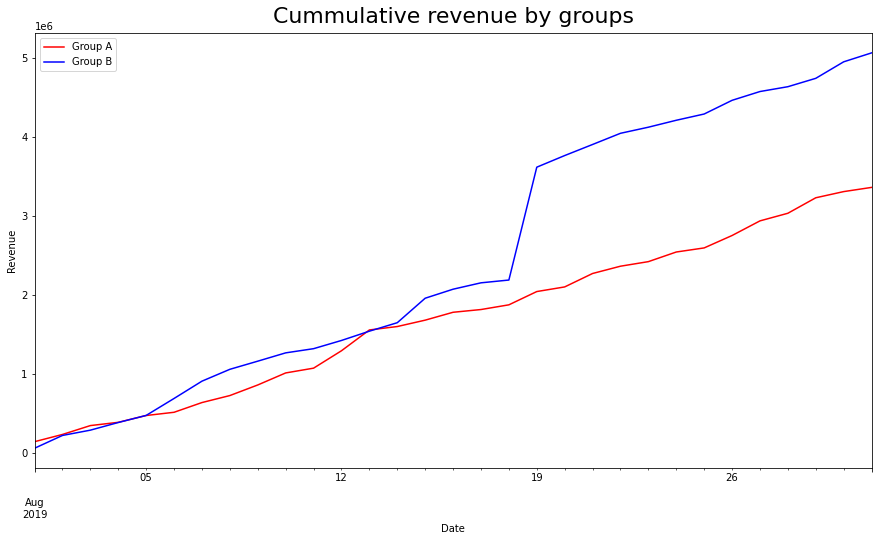

In [42]:
ax1 = ordersACummulative.plot(x='date', y='revenueCummulativeA', color='red', figsize=(15, 8), label='Group A')
ordersBCummulative.plot(ax=ax1, x='date', y='revenueCummulativeB', color='blue', figsize=(15, 8), label='Group B')
ax1.legend(loc = 'upper left')
plt.title('Cummulative revenue by groups', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show();

**На графике виден резкий скачок выручки по группе B 18 августа. Возможно имел место выборс (очень большая сумма покупки). В связи с этим скачком суммарная выручка по группе B выше более, чем на 1000000.**

Построем график среднего чека по группам

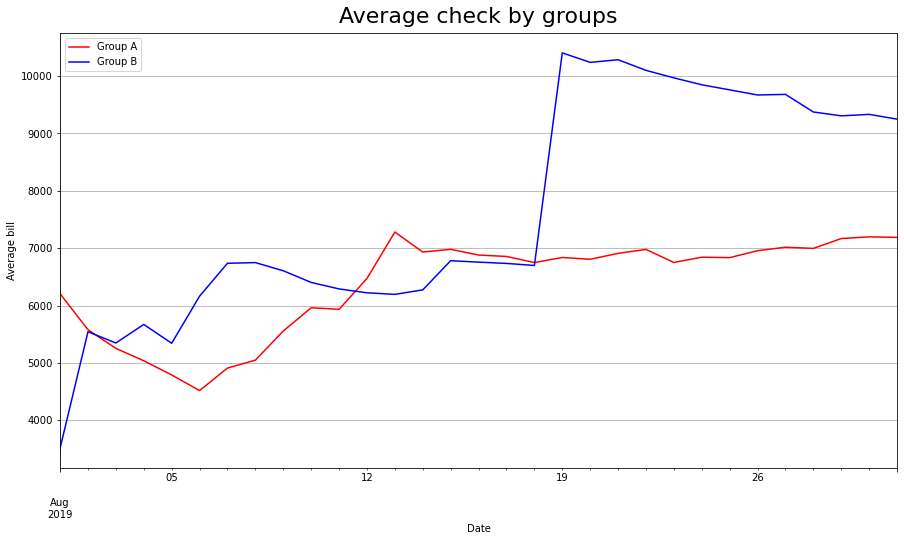

In [43]:
ax1 = ordersACummulative.plot(x='date', y='check_avgA', color='red', figsize=(15, 8), label='Group A', grid=True)
ordersBCummulative.plot(ax=ax1, x='date', y='check_avgB', color='blue', figsize=(15, 8), label='Group B', grid=True)
ax1.legend(loc = 'upper left')
plt.title('Average check by groups', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Average bill")
plt.show();

**Средний чек группы A стабилизировался после 19 числа и к 31 августа установился на уровне 7300. В результате крупной покупки 18 августа средний чек группы B сильно поскочил. После 18 сумма среднего чека начала снижаться и установилась на уровне 9100 к 31 августа. Возможно группе B нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.**

Рассмотрим график относительного различия для среднего чека. 

In [44]:
data['check_proportion'] = data['check_avgB']/data['check_avgA']-1

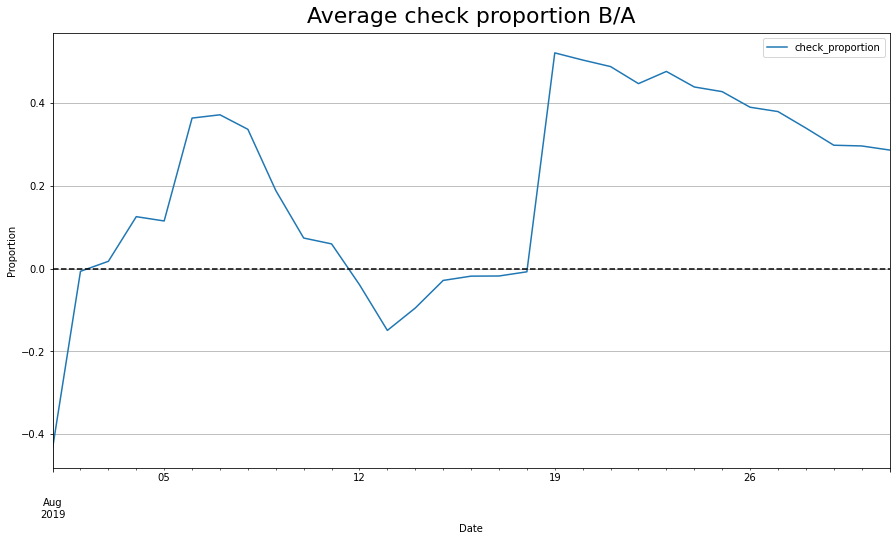

In [45]:
data.plot(x='date', y='check_proportion', figsize=(15, 8), grid=True)
plt.title('Average check proportion B/A', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.axhline(y=0, color='black', linestyle='--') 
plt.show();


**Средний чек группы B не всегда превышал средний чек группы A. Возможно был и не один крупный заказ в группе B.**  
Проанализируем график кумулятивной конверсии. 

In [46]:
data['conversionA'] = data['ordersCummulativeA'] / data['visitorsCummulativeA']
data['conversionB'] = data['ordersCummulativeB'] / data['visitorsCummulativeB']

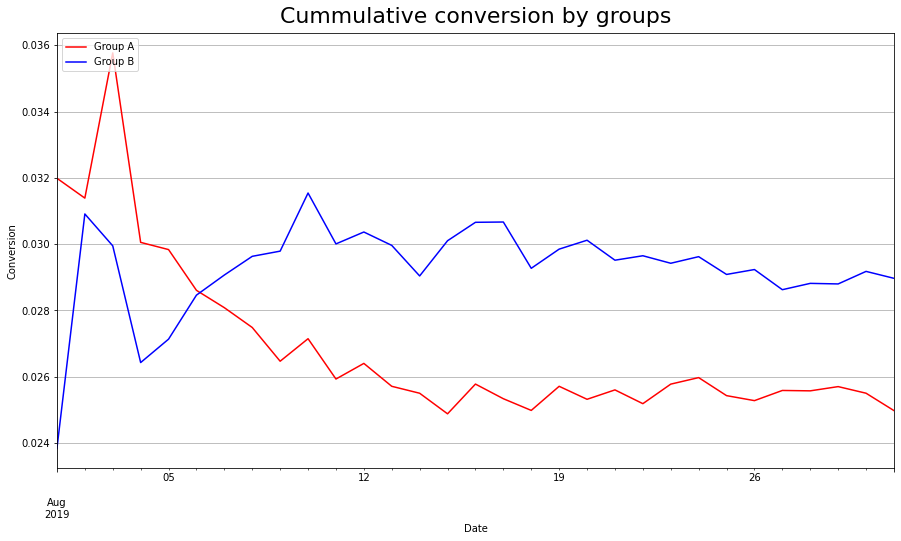

In [47]:
ax1 = data.plot(x='date', y='conversionA', color='red', figsize=(15, 8), label='Group A', grid=True)
data.plot(ax=ax1, x='date', y='conversionB', color='blue', figsize=(15, 8), label='Group B', grid=True)
ax1.legend(loc = 'upper left')
plt.title('Cummulative conversion by groups', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Conversion")
plt.show();

**Конверсии более менее стабилизировались, при этом группа B показывает конверсию выше, чем группа A примерно на 0,4%.**

Построим график относительного различия кумулятивных конверсий

In [48]:
data['conversion_proportion'] = data['conversionB']/data['conversionA']-1

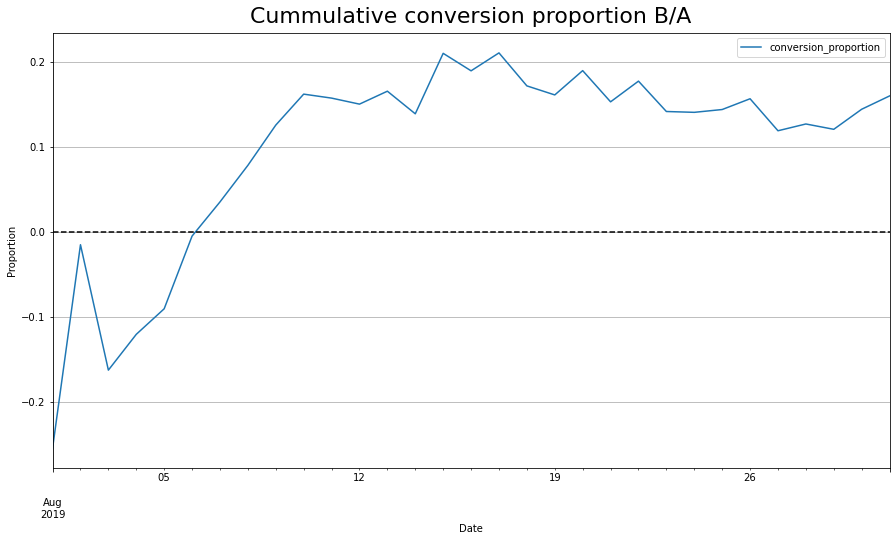

In [49]:
data.plot(x='date', y='conversion_proportion', figsize=(15, 8), grid=True)
plt.title('Cummulative conversion proportion B/A', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.axhline(y=0, color='black', linestyle='--') 
plt.show();

**Группа B стабильно конверсит лучше со второй недели теста.**

Подготовим данные для расчета критерия Манна-Уитни.

In [50]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

In [51]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [52]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [53]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Проверим гипотезу:  
HO: Различие  конверсии в группах A и B статистически незначимо.  
H1: Различие  конверсии в группах A и B статистически значимо.

In [54]:
alpha = 0.05 

results = st.mannwhitneyu(sampleA, sampleB, True, 'two-sided')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.011018084110014691
Отвергаем нулевую гипотезу: разница статистически значима


Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1.

In [55]:
"{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)

'0.160'

**По сырым данным конверсии групп B лучше конверсии группы A**

Проверим гипотезу:  
HO: Различие среднего чека в группах A и B статистически незначимо.  
H1: Различие среднего чека в группах A и B статистически значимо.

In [56]:
alpha = 0.05 

results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], True, 'two-sided')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.8294908998149533
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


А ещё найдём относительные различия в среднем чеке между группами:

In [57]:
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.287


**По сырым данным различий по среднему чеку между группами нет, хотя средний чек группы B на 29% выше среднего чека группы A.**

##### 3.2 Анализ выбросов
<a id='step3_2'></a>

Перейдем к анализу выбросов. Сгруппируем пользователей по количеству заказов.

In [58]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['visitorId','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Построем точечный график количества заказов.

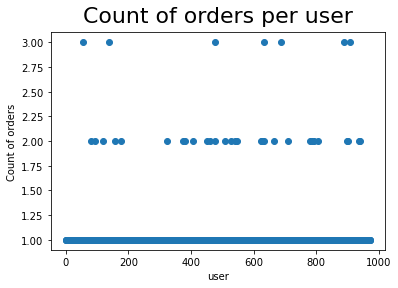

In [59]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Count of orders per user', fontsize=22, pad = 10)
plt.xlabel("user")
plt.ylabel("Count of orders")
plt.show();


In [60]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

**95% пользователей всего с 1-2 заказами. Примем 2 заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.**

Построем точечный график стоимостей заказов.

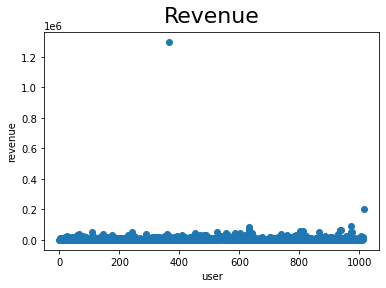

In [61]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Revenue', fontsize=22, pad = 10)
ylim=(0, 200000)
plt.xlabel("user")
plt.ylabel("revenue")
plt.show();


Большинство заказов меньше 200000. 1200000 - это видимо тот выброс за 18 августа. Увеличим график и рассчитаем выборочные перцентили.

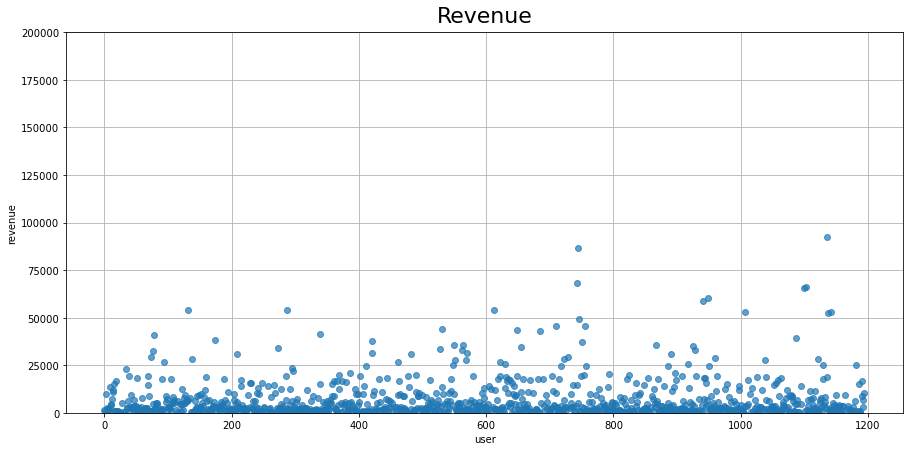

In [62]:
orders['revenue'].plot(style='o', grid=True, figsize=(15, 7), alpha=0.7, ylim=(0, 200000))
plt.title('Revenue', fontsize=22, pad = 10)
plt.xlabel("user")
plt.ylabel("revenue")
plt.show();

In [63]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

**Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Примем 26785 за нижнюю границу выручки с одного заказа, и отсеим аномальных пользователей по ней.**

Оценим различия в конверсии и среднем чеке между группами по очищенным данным.

In [64]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [65]:
abnormalUsers.shape

(58,)

In [66]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Проверим гипотезу:  
HO: Различие  конверсии в группах A и B статистически незначимо.  
H1: Различие  конверсии в группах A и B статистически значимо.

In [67]:
alpha = 0.05 

results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'two-sided')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.01235203801772639
Отвергаем нулевую гипотезу: разница статистически значима


Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1.

In [68]:
"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'0.182'

**По очищенным данным конверсии групп B также лучше конверсии группы A**

Проверим гипотезу:  
HO: Различие среднего чека в группах A и B статистически незначимо.  
H1: Различие среднего чека в группах A и B статистически значимо.

In [69]:
alpha = 0.05 

results = st.mannwhitneyu(orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], True, 'two-sided')

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.6458964038091206
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


А ещё найдём относительные различия в среднем чеке между группами:

In [70]:
"{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)

'-0.048'

**По сырым данным различий по среднему чеку между группами нет. Отметим, что по очищенным данным средний чек группы A стал выше, хотя эта разница статистически не значима.**

##### 3.3 Расчет метрик по очищенным данным.
<a id='step3_3'></a>

Рассчитаем куммулятивное количество заказов, суммарную выручку на каждый день по группам

In [71]:
good_ordersADaily = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
good_ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [72]:
good_ordersACummulative = good_ordersADaily.apply(
    lambda x: \
        good_ordersADaily[good_ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
good_ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [73]:
good_ordersBDaily = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
good_ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [74]:
good_ordersBCummulative = good_ordersBDaily.apply(
    lambda x: \
        good_ordersBDaily[good_ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
good_ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [75]:
good_ordersBCummulative['check_avgB']=good_ordersBCummulative['revenueCummulativeB']/good_ordersBCummulative['ordersCummulativeB']
good_ordersACummulative['check_avgA']=good_ordersACummulative['revenueCummulativeA']/good_ordersACummulative['ordersCummulativeA']

Соеденим все расчетные таблицы в общей таблице data_new

In [76]:
data_new = good_ordersADaily.merge(good_ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(good_ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(good_ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data_new.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,check_avgA,ordersCummulativeB,revenueCummulativeB,check_avgB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,16,54351,17,59758,16,54351,3396.937500,17,59758,3515.176471,719,713,719,713
1,2019-08-02,18,89912,21,93234,34,144263,4243.029412,38,152992,4026.105263,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,58,256736,4426.482759,52,220041,4231.557692,507,509,1845,1803
3,2019-08-04,11,41176,13,65540,69,297912,4317.565217,65,285581,4393.553846,717,770,2562,2573
4,2019-08-05,22,86383,20,61558,91,384295,4223.021978,85,347139,4083.988235,756,707,3318,3280


Построем график среднего чека по очищенным данным

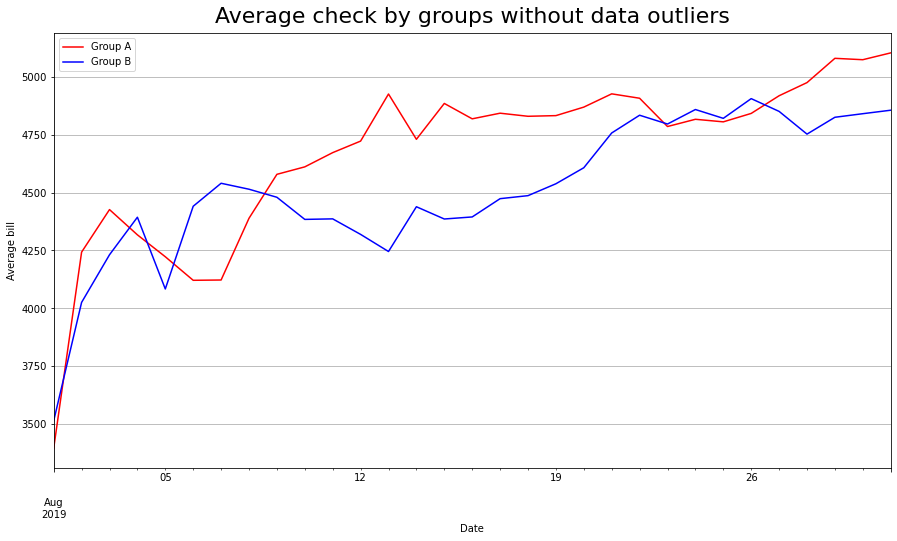

In [77]:
ax1 = good_ordersACummulative.plot(x='date', y='check_avgA', color='red', figsize=(15, 8), label='Group A', grid=True)
good_ordersBCummulative.plot(ax=ax1, x='date', y='check_avgB', color='blue', figsize=(15, 8), label='Group B', grid=True)
ax1.legend(loc = 'upper left')
plt.title('Average check by groups without data outliers', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Average bill")
plt.show();

**После удаления выбросов средний чек группы B стал даже ниже среднего чека группы A, однако эта разница несущественна. Графики стабилизировались на уровене среднего чека от 4800 до 5100 рублей.**

Оценим на графике "очищенную" конверсию.

In [78]:
data_new['conversionA'] = data_new['ordersCummulativeA'] / data_new['visitorsCummulativeA']
data_new['conversionB'] = data_new['ordersCummulativeB'] / data_new['visitorsCummulativeB']

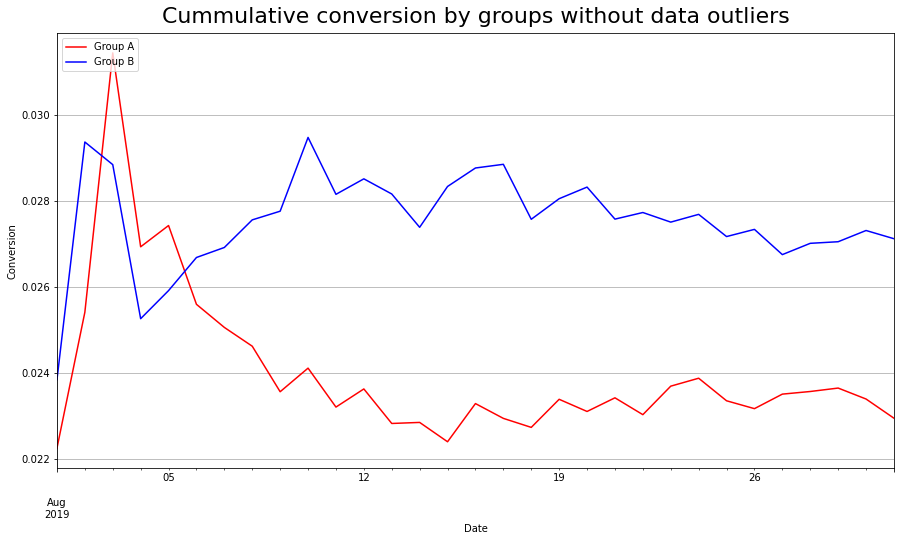

In [79]:
ax1 = data_new.plot(x='date', y='conversionA', color='red', figsize=(15, 8), label='Group A', grid=True)
data_new.plot(ax=ax1, x='date', y='conversionB', color='blue', figsize=(15, 8), label='Group B', grid=True)
ax1.legend(loc = 'upper left')
plt.title('Cummulative conversion by groups without data outliers', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Conversion")
plt.show();

**Конверсия группы B и по очищенным данным выше конверсии группы A.**

Оценим как метрики повлияли на график кумулятивной выручки

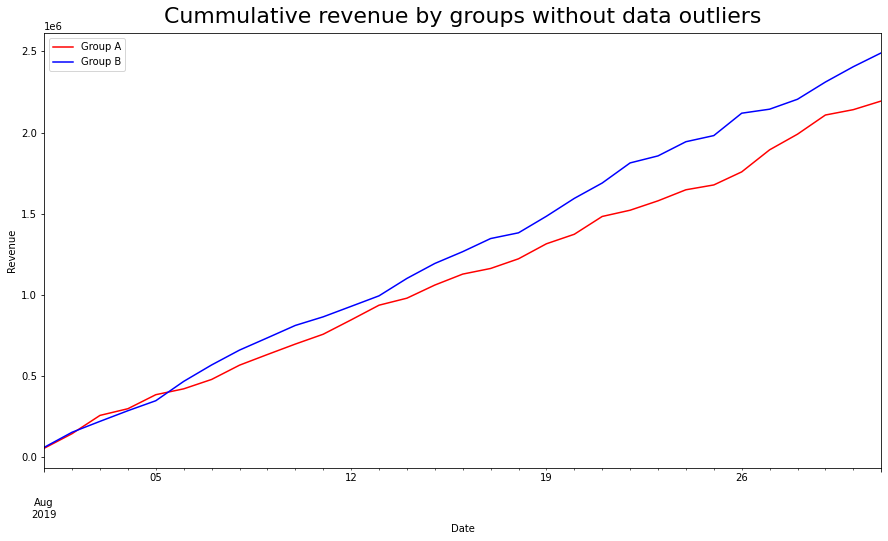

In [80]:
ax1 = good_ordersACummulative.plot(x='date', y='revenueCummulativeA', color='red', figsize=(15, 8), label='Group A')
good_ordersBCummulative.plot(ax=ax1, x='date', y='revenueCummulativeB', color='blue', figsize=(15, 8), label='Group B')
ax1.legend(loc = 'upper left')
plt.title('Cummulative revenue by groups without data outliers', fontsize=22, pad = 10)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show();

**Выручка по обеим группам равномерно растет. Однако выручка по группе B растет явно быстрее. Это результат более высокой конверсии при равном среднем чеке.** 

### Шаг 4. Общий вывод

#### В ходе приоретизации мы выявили первоочередные гипотезы для проверки:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
1. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

#### В ходе проведенного исследования мы выявили
1. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
2. Различия по конверсии между группами значимы и по «сырым», и по данным после фильтрации аномалий;
3. График куммулятивной выручки по очищенным данным сообщает, что результаты группы B лучше группы A.

**Таким образом, следует остановить и признать тест успешным, поскольку конверсия группы B лучше конверсии группы A. При равном среднем чеке группа B приносит больше прибыли.**

#### Attention
* Столбцы с датами в таблицах visitors и  orders записаны в общем формате
* 58 пользователей ошибочно попали в обе группы. Данные об их заказах не были использованы в исследовании
